In [1]:
import numpy as np
import matplotlib.pyplot as plt

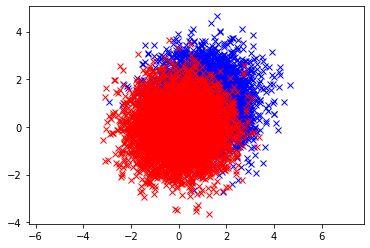

(10000, 2)
(10000, 1)


In [2]:
num_train = 5000
num_test = 1000

sig_mean = [1,1]
sig_cov = [[1,0],[0,1]]

bkg_mean = [0,0]
bkg_cov = [[1,0],[0,1]]

sig_data_train = np.random.multivariate_normal(sig_mean, sig_cov, num_train)
sig_labels_train = np.ones(len(sig_data_train))
bkg_data_train = np.random.multivariate_normal(bkg_mean, bkg_cov, num_train)
bkg_labels_train = np.zeros(len(bkg_data_train))
data_train = np.vstack((sig_data_train,bkg_data_train))
labels_train = np.hstack((sig_labels_train,bkg_labels_train)).reshape(-1,1)

sig_data_test = np.random.multivariate_normal(sig_mean, sig_cov, num_test)
sig_labels_test = np.ones(len(sig_data_test))
bkg_data_test = np.random.multivariate_normal(bkg_mean, bkg_cov, num_test)
bkg_labels_test = np.zeros(len(bkg_data_test))
data_test = np.vstack((sig_data_test,bkg_data_test))
labels_test = np.hstack((sig_labels_test,bkg_labels_test)).reshape(-1,1)

plt.plot(sig_data_train[:,0], sig_data_train[:,1], 'x',color='b')
plt.plot(bkg_data_train[:,0], bkg_data_train[:,1], 'x', color='r')
plt.axis('equal')
plt.show()

print(data_train.shape)
#print(data_train)
print(labels_train.shape)
#print(labels_train)

data = [data_train, labels_train, data_test, labels_test]

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
class Net(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Net, self).__init__()
        self.hl_1 = nn.Linear(in_feats,hidden_feats)
        self.hl_2 = nn.Linear(hidden_feats,out_feats)
    def forward(self, input):
        layer_1 = F.relu(self.hl_1(input))
        output = F.sigmoid(self.hl_2(layer_1))
        return output

In [5]:
def train(model, data, epochs=20):
    X_train, y_train, X_test, y_test = data
    X_test = torch.from_numpy(np.float32(X_test))
    y_test = torch.from_numpy(np.float32(y_test))

    history = {'train_loss':[],'test_loss':[]}
    
    mini_batch_size = 64
    minibatches = int(X_train.shape[0]/mini_batch_size)
    allindices = np.arange(X_train.shape[0])
    np.random.shuffle(allindices)

    for e in range(epochs):
        model.train()
        for i in range(minibatches):
            indices = allindices[int(i*mini_batch_size):int((i+1)*mini_batch_size-1)]
            batch_data = torch.from_numpy(np.float32(X_train[indices]))
            batch_labels = torch.from_numpy(np.float32(y_train[indices]))
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = loss_fn(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        model.eval()
        history['train_loss'].append(loss.detach().numpy())
        y_pred = model(X_test)
        test_loss = loss_fn(y_pred,y_test).detach().numpy()
        history['test_loss'].append(test_loss)
        if e%1==0:
            print('Epoch:',e,'\tTrain Loss:',round(float(loss),4),'\tTest Loss:',round(float(test_loss),4))

    return history

Epoch: 0 	Train Loss: 0.5895 	Test Loss: 0.6031
Epoch: 1 	Train Loss: 0.4971 	Test Loss: 0.5257
Epoch: 2 	Train Loss: 0.459 	Test Loss: 0.4991
Epoch: 3 	Train Loss: 0.4474 	Test Loss: 0.4931
Epoch: 4 	Train Loss: 0.4432 	Test Loss: 0.4912
Epoch: 5 	Train Loss: 0.4413 	Test Loss: 0.4902
Epoch: 6 	Train Loss: 0.4405 	Test Loss: 0.4897
Epoch: 7 	Train Loss: 0.44 	Test Loss: 0.4894
Epoch: 8 	Train Loss: 0.44 	Test Loss: 0.4891
Epoch: 9 	Train Loss: 0.4399 	Test Loss: 0.4889
Epoch: 10 	Train Loss: 0.4399 	Test Loss: 0.4887
Epoch: 11 	Train Loss: 0.4399 	Test Loss: 0.4886
Epoch: 12 	Train Loss: 0.44 	Test Loss: 0.4885
Epoch: 13 	Train Loss: 0.4401 	Test Loss: 0.4885
Epoch: 14 	Train Loss: 0.4403 	Test Loss: 0.4885
Epoch: 15 	Train Loss: 0.4405 	Test Loss: 0.4885
Epoch: 16 	Train Loss: 0.4408 	Test Loss: 0.4885
Epoch: 17 	Train Loss: 0.4411 	Test Loss: 0.4885
Epoch: 18 	Train Loss: 0.4414 	Test Loss: 0.4885
Epoch: 19 	Train Loss: 0.4415 	Test Loss: 0.4885


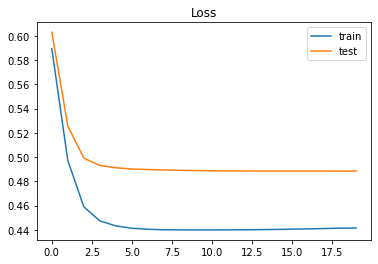

In [6]:
model = Net(2,8,1)
#print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

history = train(model, data, epochs=20)
plt.plot(history['train_loss'],label='train')
plt.plot(history['test_loss'],label='test')
plt.title("Loss")
plt.legend()
plt.show()

In [7]:
# There has to be a better way to convert numpy array to pytorch dataset with minibatches???

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


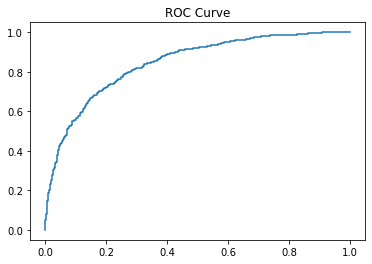

ROC AUC:  0.8446


In [8]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred = model(torch.from_numpy(np.float32(data[2]))).detach().numpy()
fpr, tpr, thresholds = roc_curve(data[3], y_pred)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
plt.show()
print("ROC AUC: ", round(roc_auc_score(data[3], y_pred),4))